# Chapter 7 Ensemble Learning and Random Forests

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

np.random.seed(42)

## Voting Classifiers

In [37]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(
    1, 10001).reshape(-1, 1)


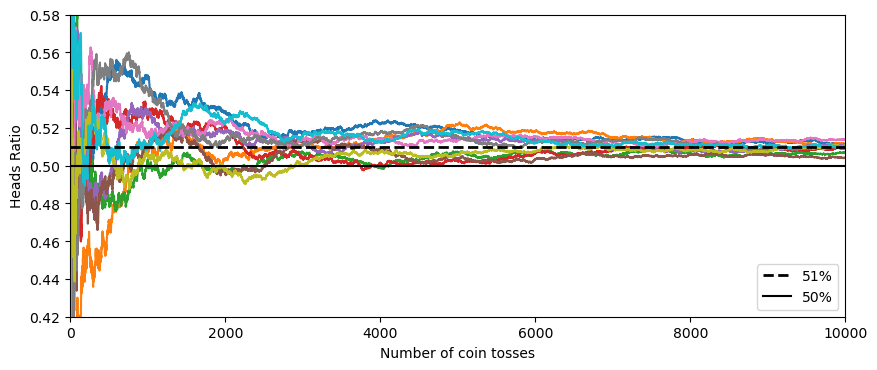

In [38]:
_, ax = plt.subplots(figsize=(10, 4), dpi=100)

ax.plot(cumulative_heads_ratio)
ax.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
ax.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
ax.set(xlabel="Number of coin tosses",
       ylabel="Heads Ratio",
       xlim=[0, 10000],
       ylim=[0.42, 0.58])
ax.legend(loc="lower right")

plt.show()

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [40]:
X, y = make_moons(n_samples=500,noise=0.3)
X_train,X_test,y_train,y_test = train_test_split(X,y)# test_size??

In [41]:
log_clf = LogisticRegression(solver="lbfgs")
rnd_clf = RandomForestClassifier()  # defalult n_estimators=100
svm_clf = SVC(gamma='scale')

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', log_clf),
                                          ('svc', svm_clf)],
                              voting='hard') 


In [42]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', LogisticRegression()), ('svc', SVC())])

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [44]:
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.816
RandomForestClassifier 0.856
SVC 0.88
VotingClassifier 0.816


### Soft voting
VotingClassifier  : `voting = 'soft'`

In [45]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf),
                                          ('svc', svm_clf)],
                              voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [46]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.816
RandomForestClassifier 0.856
SVC 0.88
VotingClassifier 0.872


## Bagging Ensembles

In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [48]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt",
                                                   max_leaf_nodes=16),
                            n_estimators=500,
                            bootstrap=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt',
                                                        max_leaf_nodes=16),
                  n_estimators=500)

In [49]:
y_pred = bag_clf.predict(X_test)

In [50]:
print(bag_clf.__class__.__name__,f"accuracy_score:{accuracy_score(y_test,y_pred)}")

BaggingClassifier accuracy_score:0.872


In [51]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [52]:
y_pred_tree = tree_clf.predict(X_test)
print(tree_clf.__class__.__name__, f"accuracy score:{accuracy_score(y_test,y_pred_tree)}")

DecisionTreeClassifier accuracy score:0.824


### Decision boundary of a single Decision Tree and the deci‐sion boundary of a bagging ensemble of 500 trees compare

In [53]:
from matplotlib.colors import ListedColormap

In [63]:
def make_mesh(lims, h):
    x = np.linspace(lims[0], lims[1], h)
    y = np.linspace(lims[2], lims[3], h)
    xx, yy = np.meshgrid(x, y)
    return xx, yy

decision boudary plot function

In [68]:
def plot_decision_boundary(clf,X,y,ax,lims=[-1.5,2.45,-1,1.5],contour=True):
    x1,x2 = make_mesh(lims,100)
    X_new = np.c_[x1.flatten(), x2.flatten()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    ax.contourf(x1,x2,y_pred, alpha=0.3,cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        ax.contour(x1,x2,y_pred,cmap=custom_cmap2,alpha=0.8)
    ax.plot(X[:,0][y == 0], X[:,1][y ==0],"yo",alpha=0.2)
    ax.plot(X[:,0][y == 1],X[:,1][y == 1],"bs", alpha=0.2)
    ax.set(xlabel="$x_1$",ylabel="$x_2$")

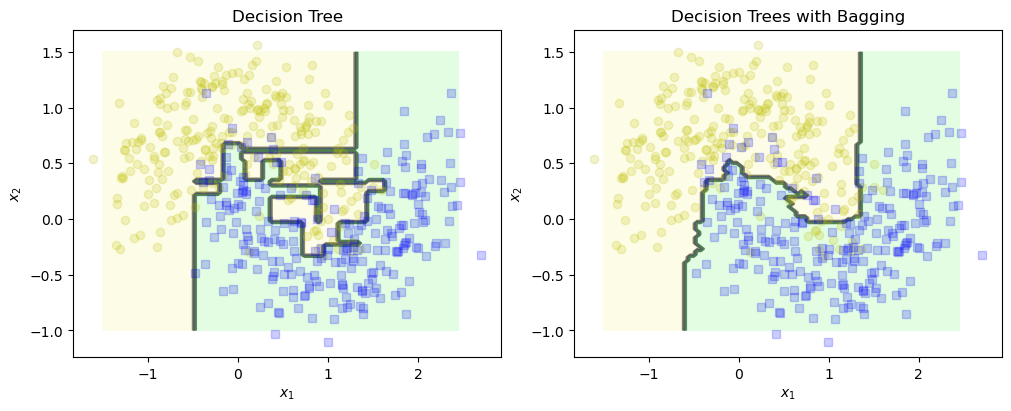

In [73]:
_, axes = plt.subplots(1,2,figsize=(10,4),dpi=100,constrained_layout=True)

plot_decision_boundary(tree_clf,X,y,ax=axes[0])
axes[0].set(title="Decision Tree")
plot_decision_boundary(bag_clf,X,y,ax=axes[1])
axes[1].set(title="Decision Trees with Bagging")

plt.show()

## RandomForests

In [74]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt",
                                                   max_leaf_nodes=16),
                            n_estimators=500)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


In [76]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [77]:
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16)
rnd_clf.fit(X_train,y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [79]:
# Very Similar predicitions:
np.sum(y_pred == y_pred_rf),len(y_pred)

(125, 125)

In [80]:
from sklearn.datasets import load_iris
iris = load_iris()

In [81]:
rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(iris["data"],iris["target"])
for name, score in zip(iris["feature_names"],rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10608846358813358
sepal width (cm) 0.024908769965987856
petal length (cm) 0.4557450590375108
petal width (cm) 0.4132577074083678


In [82]:
rnd_clf.feature_importances_

array([0.10608846, 0.02490877, 0.45574506, 0.41325771])

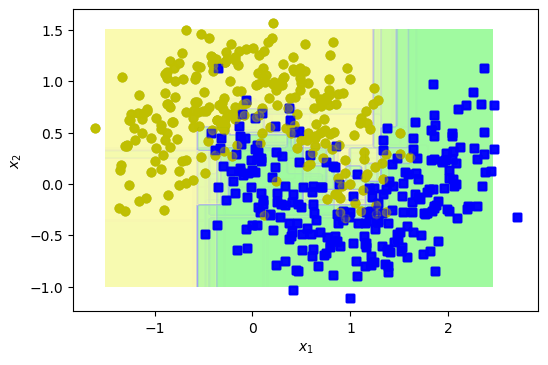

In [87]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf,
                           X,
                           y,
                           ax,
                           lims=[-1.5, 2.45, -1, 1.5],
                           contour=False)

plt.show()

In [89]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,bootstrap=True,oob_score=True)
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.8933333333333333

In [91]:
bag_clf.oob_decision_function_[:5]

array([[0.66091954, 0.33908046],
       [0.00502513, 0.99497487],
       [1.        , 0.        ],
       [0.01104972, 0.98895028],
       [0.99447514, 0.00552486]])

In [93]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.856

### Feature importance

In [94]:
# from sklearn.datasets import fetch_openml

In [101]:
# X,y = fetch_openml('mnist_784',version=1,as_frame=True,return_X_y=True,data_home='data')
# y = y.astype(np.int8)

## pyarrow dependence

In [100]:
# X.to_feather('../data/mnist_784_X.feather')
# y.to_frame().to_feather('../data/minist_784_y.feather')

In [103]:
X = pd.read_feather('../data/mnist_784_X.feather').to_numpy()
y = pd.read_feather('../data/mnist_784_y.feather').to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])